# 01 — Exploratory Data Analysis

**Goal (Task 1):** Get acquainted with the dataset before touching embeddings.

Questions:
1. How many replicates per compound?
2. How many compounds have biological-activity annotations?
3. How many unique target and pathway labels exist?
4. What does the source / batch structure look like?
5. How many sources have scalar image-feature data?
6. Which scalar features are correlated or anti-correlated?
7. Sanity-check the expected relationships the prompt documents.


## 0  Setup & load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import itertools

sns.set_style("whitegrid")
plt.rcParams.update({"figure.dpi": 100, "figure.figsize": (10, 5)})

# ── adjust this path to where you put the parquet ──
DATA_PATH = Path("./phh_prod_image_data_oasis_with_dmso.parquet")

df = pd.read_parquet(DATA_PATH)
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())


Shape: (24576, 28)

Columns:
['well_id', 'brightfield', 'compound_id', 'plate', 'source', 'library', 'compound_concentration_um', 'compound_pathway', 'compound_target', 'compound_biological_activity', 'ldh_ridge_norm', 'mtt_ridge_norm', 'bioactivity_svc_tvn_pca_platenorm_coral_regnorm_all_n_components_256', 'mean_nuclei_count', 'mean_nuclei_count_ridge_norm', 'mean_nuclei_count_ridge_norm_inv', 'mean_nuclei_area_mean', 'mean_nuclei_area_mean_ridge_norm_inv', 'cyto_area_ratio', 'cyto_area_ratio_ridge_norm', 'vacuole_sum', 'vacuole_ratio', 'mito_puncta_ratio', 'mito_puncta_ratio_ridge_norm_sub', 'ros_stress_granules_sum_mean_norm_ridge_norm_corr', 'pca_embedding_raw', 'pca_embedding_normalized', 'batch']


In [2]:
df

,well_id,brightfield,compound_id,plate,source,library,compound_concentration_um,compound_pathway,compound_target,compound_biological_activity,...,cyto_area_ratio,cyto_area_ratio_ridge_norm,vacuole_sum,vacuole_ratio,mito_puncta_ratio,mito_puncta_ratio_ridge_norm_sub,ros_stress_granules_sum_mean_norm_ridge_norm_corr,pca_embedding_raw,pca_embedding_normalized,batch
0,assayworks_prod_26_p=plate_41002887_r=12_c=4,"[0.93729806, 1.0352775, -0.028921468, 0.789490...",Pendimethalin,plate_41002887,assayworks_prod_26,oasis,0.410788,Others,Others,Pendimethalin is an herbicide that controls an...,...,0.881963,0.972280,5036.314160,0.026389,0.062928,0.057159,1.066711,"[1.2252874, 0.8416163, 0.8380041, -0.13903427,...","[0.5089693665504456, 0.3358606696128845, 0.710...",26
1,assayworks_prod_30_p=plate_41002959_r=2_c=1,"[0.95144075, 1.0327318, -0.12601289, 0.8772774...",NaN,plate_41002959,assayworks_prod_30,aw,1.000000,NaN,NaN,NaN,...,0.904101,0.975646,5437.552865,-0.004468,0.063556,0.052009,1.072008,"[1.4543848, 0.7214627, -0.7426548, 0.010571957...","[-0.592965841293335, 2.224761962890625, -0.170...",30
2,assayworks_prod_27_p=plate_41002893_r=6_c=17,"[0.98840046, 0.9932353, -0.13563196, 0.8026339...",Topiramate,plate_41002893,assayworks_prod_27,oasis,33.500000,Membrane Transporter/Ion Channel; Metabolic En...,Calcium Channel; Carbonic Anhydrase; GABA Rece...,Topiramate (McN 4853) is a broad-spectrum anti...,...,0.877046,1.061592,5238.364437,0.019123,0.057660,0.000000,0.995820,"[2.7286077, 0.8963164, -2.0839815, 0.7189002, ...","[0.011921578086912632, 0.43876028060913086, -1...",27
3,assayworks_prod_25_p=plate_41002690_r=10_c=18,"[0.98799694, 0.933732, -0.17537309, 0.8915127,...",Edoxaban (tosylate),plate_41002690,assayworks_prod_25,oasis,0.410788,Metabolic Enzyme/Protease,Factor Xa; Thrombin,Edoxaban (DU-176b) tosylate is an orally activ...,...,0.770332,0.956352,4070.985612,0.014319,0.059970,0.012229,0.989009,"[7.7684197, -0.61695874, -1.5248098, -0.79774,...","[1.5688613653182983, -0.1829252541065216, -0.7...",25
4,assayworks_prod_26_p=plate_41002883_r=14_c=10,"[0.97732073, 0.9735048, -0.08564108, 0.8179220...",Alpha-Naphthoflavone,plate_41002883,assayworks_prod_26,oasis,0.045643,Apoptosis; Immunology/Inflammation; Metabolic ...,Apoptosis; Aryl Hydrocarbon Receptor; Cytochro...,Alpha-Naphthoflavone is an orally active flavo...,...,0.974168,0.986994,5585.283604,-0.044360,0.063972,0.035530,0.983419,"[-3.8587637, 1.0842285, -2.4784412, 0.64087963...","[-1.0246893167495728, 0.4297616183757782, -1.1...",26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24571,assayworks_prod_30_p=plate_41002947_r=5_c=20,"[0.91430104, 0.87076485, -0.03136946, 0.875229...",Quinidine (15% dihydroquinidine),plate_41002947,assayworks_prod_30,oasis,100.000000,Anti-infection; Apoptosis; Membrane Transporte...,Apoptosis; Cytochrome P450; Parasite; Potassiu...,Quinidine (15% dihydroquinidine) is an antiarr...,...,0.814472,0.913897,8676.119954,0.776639,0.064958,0.000000,1.315951,"[1.0175481, -2.8254576, 1.7010531, 2.1934435, ...","[1.416452169418335, -1.5919439792633057, 1.176...",30
24572,assayworks_prod_30_p=plate_41002944_r=13_c=22,"[0.93981653, 0.87661356, -6.164883e-05, 0.8585...",NaN,plate_41002944,assayworks_prod_30,aw,0.410788,NaN,NaN,NaN,...,0.878012,0.995182,4337.535547,0.022663,0.062919,0.000000,1.074108,"[-0.2635708, -2.34933, 1.4459143, -1.2831745, ...","[-0.3714980483055115, -0.1716623455286026, 0.2...",30
24573,assayworks_prod_27_p=plate_41002907_r=4_c=9,"[0.9064085, 0.9961549, -0.0040002684, 0.835548...",5-Aminosalicylic Acid,plate_41002907,assayworks_prod_27,oasis,1.000000,Cell Cycle/DNA Damage; Cytoskeleton; Metabolic...,Endogenous Metabolite; NF-κB; PAK; PPAR,5-Aminosalicylic acid (Mesalamine) acts as a s...,...,0.957366,1.009591,5000.192326,-0.066468,0.057046,0.000000,1.013776,"[-1.591691, 0.47541845, 1.3613834, -1.9741192,...","[-0.5600079298019409, -1.0736349821090698, 0.9...",27
24574,assayworks_prod_27_p=plat

## 1  Column inventory

Categorize columns into logical groups.

In [3]:
# These are the groups the assignment defines explicitly.
METADATA      = ["library", "source", "plate", "well_id"]
PERTURBATION  = ["compound_id", "compound_concentration_um"]
ANNOTATIONS   = ["compound_biological_activity", "compound_target", "compound_pathway"]
EMBEDDINGS    = ["brightfield", "pca_embedding_raw", "pca_embedding_normalized"]

# Everything that is NOT in the above lists is a scalar numeric feature
# (assay readouts + image-segmentation features).
SCALAR_FEATURES = [
    c for c in df.columns
    if c not in METADATA + PERTURBATION + ANNOTATIONS + EMBEDDINGS
]

print("Metadata cols      :", METADATA)
print("Perturbation cols  :", PERTURBATION)
print("Annotation cols    :", ANNOTATIONS)
print("Embedding cols     :", EMBEDDINGS)
print(f"Scalar features    : {len(SCALAR_FEATURES)} columns")
print("  ->", SCALAR_FEATURES)


Metadata cols      : ['library', 'source', 'plate', 'well_id']
Perturbation cols  : ['compound_id', 'compound_concentration_um']
Annotation cols    : ['compound_biological_activity', 'compound_target', 'compound_pathway']
Embedding cols     : ['brightfield', 'pca_embedding_raw', 'pca_embedding_normalized']
Scalar features    : 16 columns
  -> ['ldh_ridge_norm', 'mtt_ridge_norm', 'bioactivity_svc_tvn_pca_platenorm_coral_regnorm_all_n_components_256', 'mean_nuclei_count', 'mean_nuclei_count_ridge_norm', 'mean_nuclei_count_ridge_norm_inv', 'mean_nuclei_area_mean', 'mean_nuclei_area_mean_ridge_norm_inv', 'cyto_area_ratio', 'cyto_area_ratio_ridge_norm', 'vacuole_sum', 'vacuole_ratio', 'mito_puncta_ratio', 'mito_puncta_ratio_ridge_norm_sub', 'ros_stress_granules_sum_mean_norm_ridge_norm_corr', 'batch']


## 2  Basic counts

Total wells, unique compounds, DMSO vs bioactive split, sources, plates, batches.

In [4]:
n_wells      = len(df)
n_compounds  = df["compound_id"].nunique()
n_dmso       = (df["compound_id"] == "DMSO").sum()
n_bioactive  = n_wells - n_dmso
n_sources    = df["source"].nunique()
n_plates     = df["plate"].nunique()

# 'batch' may or may not exist; check gracefully
n_batches    = df["batch"].nunique() if "batch" in df.columns else "column not present"

print(f"Total wells            : {n_wells:,}")
print(f"Unique compounds       : {n_compounds:,}   (includes DMSO)")
print(f"DMSO wells (controls)  : {n_dmso:,}")
print(f"Bioactive wells        : {n_bioactive:,}")
print(f"Unique sources         : {n_sources}")
print(f"Unique plates          : {n_plates}")
print(f"Unique batches         : {n_batches}")


Total wells            : 24,576
Unique compounds       : 1,098   (includes DMSO)
DMSO wells (controls)  : 4,416
Bioactive wells        : 20,160
Unique sources         : 4
Unique plates          : 64
Unique batches         : 4


## 3  Replicate structure

*How many wells per compound?*  Check the distribution across all bioactive compounds and also across DMSO separately.

=== Bioactive compounds — wells-per-compound distribution ===
8        9
16    1087
24       1

Median replicates : 16.0
Mean replicates   : 15.94

=== DMSO wells total : 4416 ===


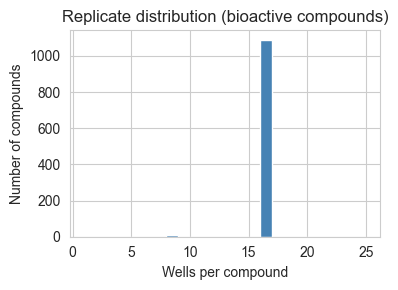

In [7]:
# --- bioactive compounds ---
reps_bio = (
    df[df["compound_id"] != "DMSO"]
    .groupby("compound_id")
    .size()
)

print("=== Bioactive compounds — wells-per-compound distribution ===")
print(reps_bio.value_counts().sort_index().to_string())
print(f"\nMedian replicates : {reps_bio.median()}")
print(f"Mean replicates   : {reps_bio.mean():.2f}")

# --- DMSO ---
print(f"\n=== DMSO wells total : {n_dmso} ===")

# --- quick histogram ---
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(reps_bio.values, bins=range(1, reps_bio.max() + 2), edgecolor="white", color="steelblue")
ax.set_xlabel("Wells per compound"); ax.set_ylabel("Number of compounds")
ax.set_title("Replicate distribution (bioactive compounds)")
plt.tight_layout(); plt.show()


## 4  Dose distribution

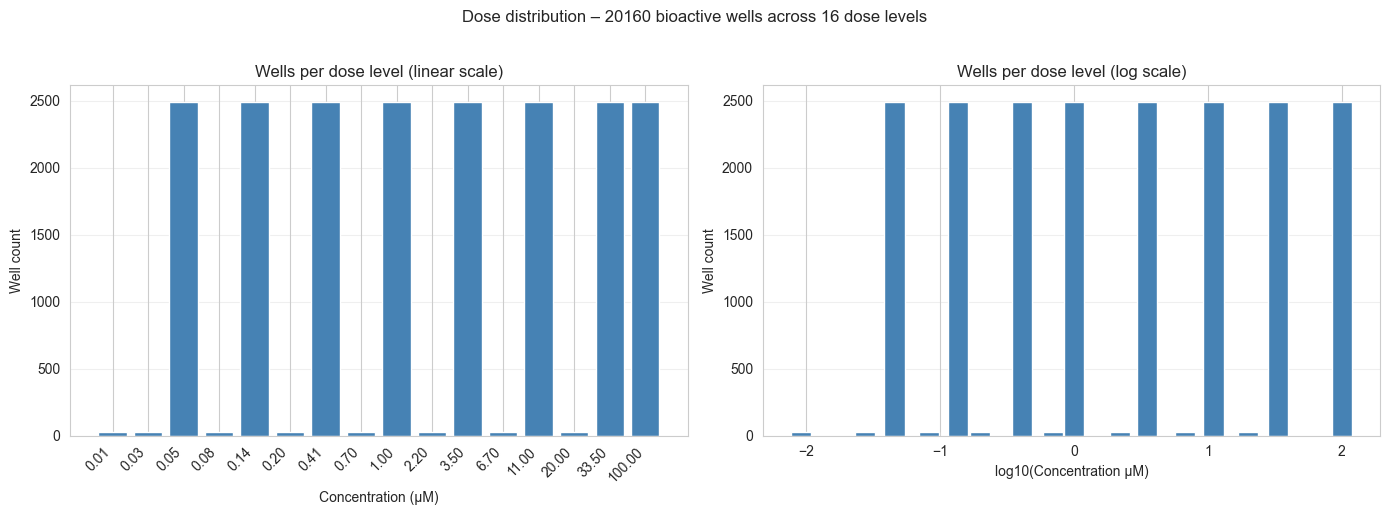


   Dose (µM)     Wells   % of bioactive
----------------------------------------
       0.009        30             0.1%
       0.027        30             0.1%
       0.046      2490            12.4%
       0.082        30             0.1%
       0.137      2490            12.4%
       0.200        30             0.1%
       0.411      2490            12.4%
       0.700        30             0.1%
       1.000      2490            12.4%
       2.200        30             0.1%
       3.500      2490            12.4%
       6.700        30             0.1%
      11.000      2490            12.4%
      20.000        30             0.1%
      33.500      2490            12.4%
     100.000      2490            12.4%


In [9]:
# Visualization for discrete dose levels
conc = df.loc[df["compound_id"] != "DMSO", "compound_concentration_um"].dropna()

# Count wells at each dose
dose_counts = conc.value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot - linear scale
axes[0].bar(range(len(dose_counts)), dose_counts.values, color="steelblue", edgecolor="white")
axes[0].set_xticks(range(len(dose_counts)))
axes[0].set_xticklabels([f"{d:.2f}" for d in dose_counts.index], rotation=45, ha="right")
axes[0].set_xlabel("Concentration (µM)")
axes[0].set_ylabel("Well count")
axes[0].set_title("Wells per dose level (linear scale)")
axes[0].grid(axis="y", alpha=0.3)

# Bar plot - log scale x-axis
log_doses = np.log10(dose_counts.index)
axes[1].bar(log_doses, dose_counts.values, width=0.15, color="steelblue", edgecolor="white")
axes[1].set_xlabel("log10(Concentration µM)")
axes[1].set_ylabel("Well count")
axes[1].set_title("Wells per dose level (log scale)")
axes[1].grid(axis="y", alpha=0.3)

plt.suptitle(f"Dose distribution – {len(conc)} bioactive wells across {len(dose_counts)} dose levels", y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'Dose (µM)':>12s}  {'Wells':>8s}  {'% of bioactive':>15s}")
print("-" * 40)
for dose, count in dose_counts.items():
    print(f"{dose:>12.3f}  {count:>8d}  {100*count/len(conc):>14.1f}%")


Notes:

* 2 tiers of dosing: 8 "major" doses (~2490 wells each, 12.4% bioactive) ; 8 "minor" doses (30 wells each, 0.1% bioactive)
* most compounds tested at 8 main concentrations and smaller subset tested at intermediate doses for finer resolution

## 5  Annotation coverage

*How many compounds have biological-activity annotations?*  Deduplicate to one row per compound first to avoid double-count replicates.

In [10]:
# one row per compound
comp = df.drop_duplicates(subset=["compound_id"]).set_index("compound_id")

for col in ANNOTATIONS:
    # a value counts as "present" if it is not NaN and not empty/whitespace
    has = comp[col].notna() & (comp[col].astype(str).str.strip() != "")
    print(f"{col:42s}: {has.sum():5d} / {len(comp)} compounds  "
          f"({100 * has.mean():.1f} %)")


compound_biological_activity              :  1048 / 1099 compounds  (95.4 %)
compound_target                           :  1049 / 1099 compounds  (95.5 %)
compound_pathway                          :  1049 / 1099 compounds  (95.5 %)


## 6  Unique targets & pathways

*How many unique target and pathway annotations are there?*

Both columns are **multi-label** — values are separated by `"; "` (semicolon + space).  We explode them and count.

In [11]:
def explode_labels(series, sep="; "):
    """Split a multi-label string column into one label per row."""
    return (
        series.dropna()
        .str.split(sep)
        .explode()
        .str.strip()
        .replace("", pd.NA)
        .dropna()
    )

# use per-compound (deduplicated) series so frequency = # compounds
targets   = explode_labels(comp["compound_target"])
pathways  = explode_labels(comp["compound_pathway"])

print(f"Unique targets  : {targets.nunique()}")
print(f"Unique pathways : {pathways.nunique()}")

# --- top targets ---
print("\n── Top 25 targets (by # compounds) ──")
print(targets.value_counts().head(25).to_string())


Unique targets  : 254
Unique pathways : 22

── Top 25 targets (by # compounds) ──
compound_target
Bacterial                     168
Apoptosis                     157
Autophagy                     141
Antibiotic                    124
Endogenous Metabolite          96
Others                         70
Parasite                       60
Fungal                         49
COX                            42
Adrenergic Receptor            41
5-HT Receptor                  41
HIV                            41
Cytochrome P450                32
Calcium Channel                29
Potassium Channel              28
Histamine Receptor             26
Sodium Channel                 24
Dopamine Receptor              24
DNA/RNA Synthesis              22
Ferroptosis                    19
Reactive Oxygen Species        18
VEGFR                          18
Biochemical Assay Reagents     18
SARS-CoV                       17
Mitophagy                      17


In [12]:
# --- top pathways ---
print("── Top 25 pathways (by # compounds) ──")
print(pathways.value_counts().head(25).to_string())


── Top 25 pathways (by # compounds) ──
compound_pathway
Anti-infection                         305
Metabolic Enzyme/Protease              272
Neuronal Signaling                     222
GPCR/G Protein                         190
Apoptosis                              177
Autophagy                              141
Immunology/Inflammation                131
Membrane Transporter/Ion Channel       125
Cell Cycle/DNA Damage                  110
Others                                  96
Vitamin D Related/Nuclear Receptor      63
Protein Tyrosine Kinase/RTK             60
NF-κB                                   38
Epigenetics                             33
Stem Cell/Wnt                           28
JAK/STAT Signaling                      23
MAPK/ERK Pathway                        23
PI3K/Akt/mTOR                           17
Cytoskeleton                            12
PROTAC                                   7
TGF-beta/Smad                            7
Antibody-drug Conjugate/ADC Related      

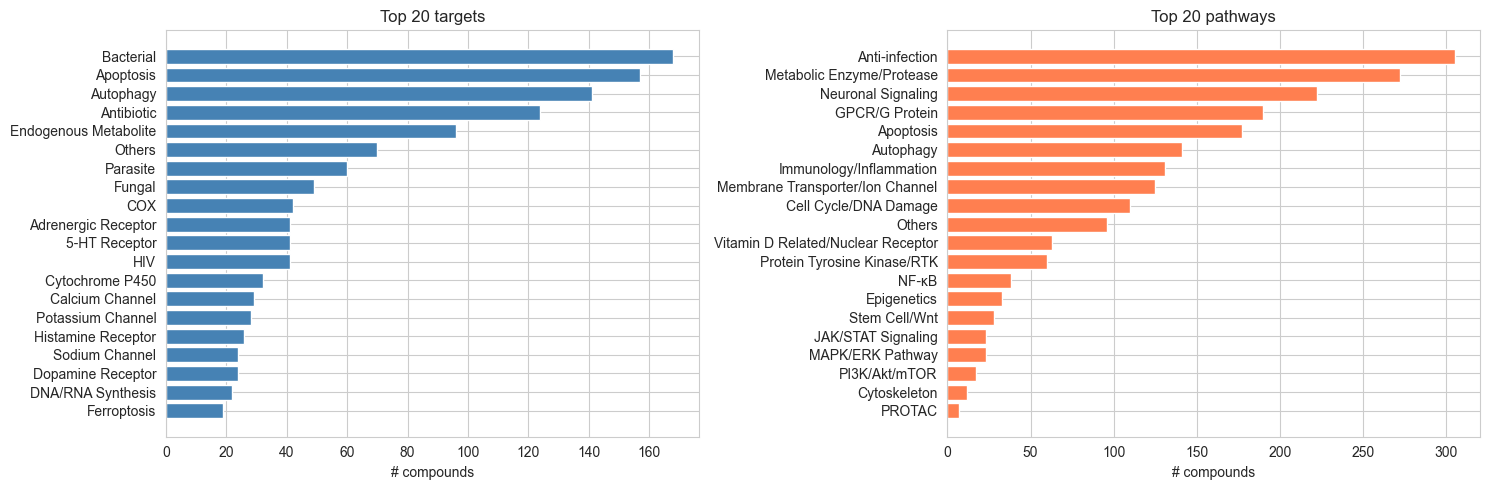

In [14]:
# --- bar charts ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

top_t = targets.value_counts().head(20)
axes[0].barh(top_t.index[::-1], top_t.values[::-1], color="steelblue")
axes[0].set_xlabel("# compounds")
axes[0].set_title("Top 20 targets")

top_p = pathways.value_counts().head(20)
axes[1].barh(top_p.index[::-1], top_p.values[::-1], color="coral")
axes[1].set_xlabel("# compounds")
axes[1].set_title("Top 20 pathways")

plt.tight_layout(); plt.show()


## 7  Source & batch structure

*Check source and batch?*

In [15]:
print("=== Wells per source ===")
print(df["source"].value_counts().sort_index().to_string())

if "batch" in df.columns:
    print("\n=== Wells per batch ===")
    print(df["batch"].value_counts().sort_index().to_string())

    print("\n=== Sources × Batches cross-tab ===")
    print(pd.crosstab(df["source"], df["batch"]).to_string())


=== Wells per source ===
source
assayworks_prod_25    6144
assayworks_prod_26    6144
assayworks_prod_27    6144
assayworks_prod_30    6144

=== Wells per batch ===
batch
25    6144
26    6144
27    6144
30    6144

=== Sources × Batches cross-tab ===
batch                 25    26    27    30
source                                    
assayworks_prod_25  6144     0     0     0
assayworks_prod_26     0  6144     0     0
assayworks_prod_27     0     0  6144     0
assayworks_prod_30     0     0     0  6144


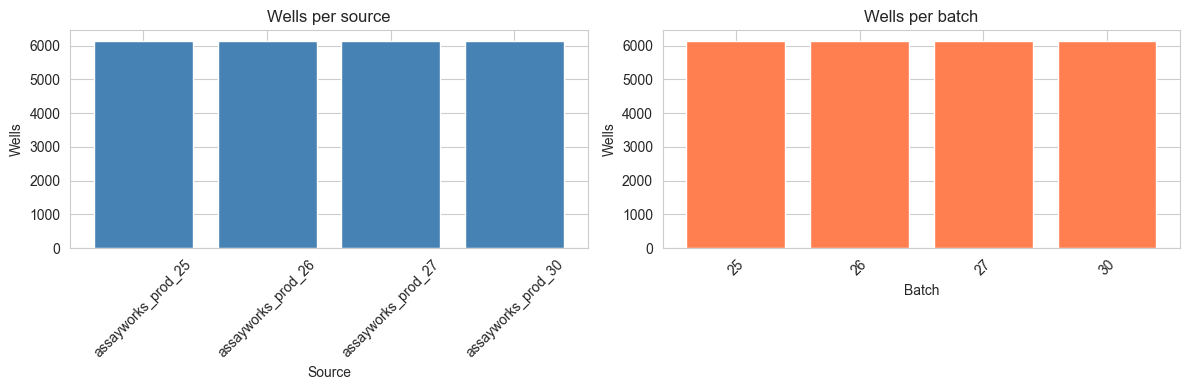

In [17]:
# visual
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

src_vc = df["source"].value_counts().sort_index()
axes[0].bar(src_vc.index.astype(str), src_vc.values, color="steelblue")
axes[0].set_xlabel("Source"); axes[0].set_ylabel("Wells")
axes[0].set_title("Wells per source")
axes[0].tick_params(axis="x", rotation=45)

if "batch" in df.columns:
    bat_vc = df["batch"].value_counts().sort_index()
    axes[1].bar(bat_vc.index.astype(str), bat_vc.values, color="coral")
    axes[1].set_xlabel("Batch"); axes[1].set_ylabel("Wells")
    axes[1].set_title("Wells per batch")
    axes[1].tick_params(axis="x", rotation=45)
else:
    axes[1].text(0.5, 0.5, "No 'batch' column", ha="center", va="center",
                 transform=axes[1].transAxes)

plt.tight_layout(); plt.show()


## 8  Image-feature coverage per source

*How many sources have image-feature data?*  We check what fraction of wells in each source have non-null values for each scalar feature.

In [19]:
# cast to numeric (some cols may be object)
feat_numeric = df[SCALAR_FEATURES].apply(pd.to_numeric, errors="coerce")

# coverage = fraction non-null, grouped by source
coverage = (
    feat_numeric
    .assign(source=df["source"])
    .groupby("source")
    .apply(lambda g: g[SCALAR_FEATURES].notna().mean(), include_groups=False)
)

print("Feature coverage by source (fraction of wells with non-null value):\n")
print(coverage.round(3).to_string())


Feature coverage by source (fraction of wells with non-null value):

                    ldh_ridge_norm  mtt_ridge_norm  bioactivity_svc_tvn_pca_platenorm_coral_regnorm_all_n_components_256  mean_nuclei_count  mean_nuclei_count_ridge_norm  mean_nuclei_count_ridge_norm_inv  mean_nuclei_area_mean  mean_nuclei_area_mean_ridge_norm_inv  cyto_area_ratio  cyto_area_ratio_ridge_norm  vacuole_sum  vacuole_ratio  mito_puncta_ratio  mito_puncta_ratio_ridge_norm_sub  ros_stress_granules_sum_mean_norm_ridge_norm_corr  batch
source                                                                                                                                                                                                                                                                                                                                                                                                                                                          
assayworks_prod_25           1.00

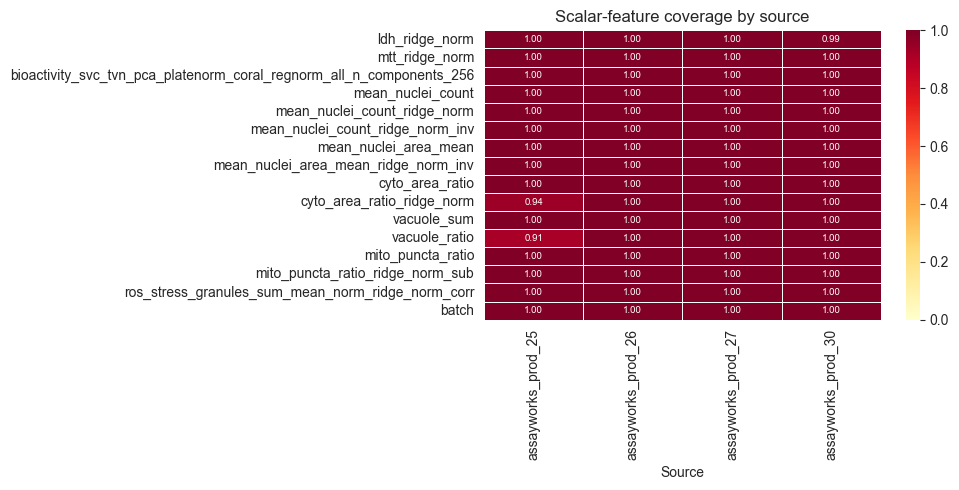

In [23]:
# heat-map of coverage
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(
    coverage.T,
    annot=True, fmt=".2f",
    cmap="YlOrRd", vmin=0, vmax=1,
    linewidths=0.5, ax=ax,
    annot_kws={"size": 7},
)
ax.set_title("Scalar-feature coverage by source")
ax.set_xlabel("Source")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # <-- add this
plt.tight_layout(); plt.show()


## 9  Scalar-feature correlations

*Which features are correlated, and which are anti-correlated?*

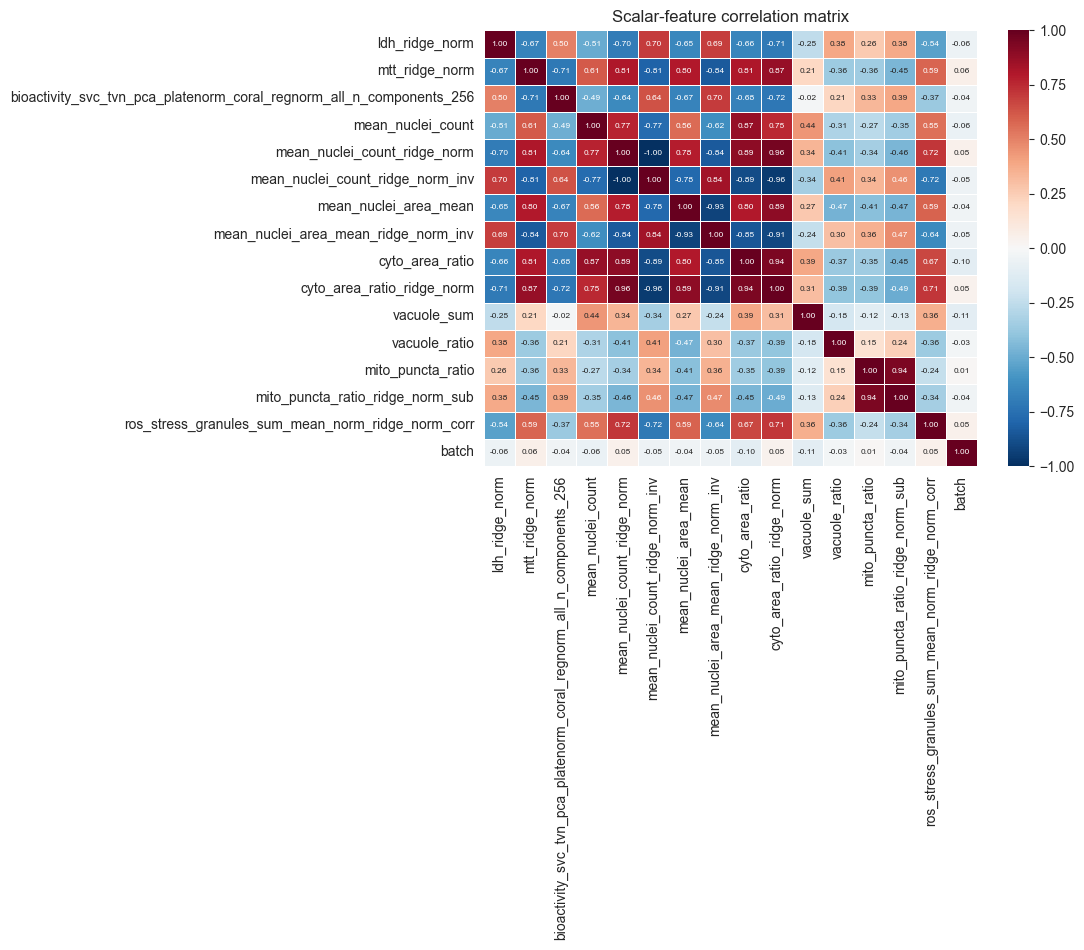

In [24]:
corr = feat_numeric.corr()

fig, ax = plt.subplots(figsize=(max(10, len(SCALAR_FEATURES)*0.7),
                                max(8,  len(SCALAR_FEATURES)*0.6)))
sns.heatmap(
    corr, cmap="RdBu_r", center=0, vmin=-1, vmax=1,
    annot=True, fmt=".2f", linewidths=0.4, ax=ax,
    annot_kws={"size": 6},
)
ax.set_title("Scalar-feature correlation matrix")
plt.tight_layout(); plt.show()


In [25]:
# --- ranked list of strongest pairs (excluding self-correlations) ---
pairs = []
for a, b in itertools.combinations(corr.index, 2):
    pairs.append((a, b, corr.loc[a, b]))
pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("Top 15 correlated / anti-correlated feature pairs:\n")
print(f"{'Feature A':<48s} {'Feature B':<48s} {'r':>7s}")
print("-" * 107)
for a, b, r in pairs[:15]:
    print(f"{a:<48s} {b:<48s} {r:>+7.3f}")


Top 15 correlated / anti-correlated feature pairs:

Feature A                                        Feature B                                              r
-----------------------------------------------------------------------------------------------------------
mean_nuclei_count_ridge_norm                     mean_nuclei_count_ridge_norm_inv                  -1.000
mean_nuclei_count_ridge_norm_inv                 cyto_area_ratio_ridge_norm                        -0.955
mean_nuclei_count_ridge_norm                     cyto_area_ratio_ridge_norm                        +0.955
mito_puncta_ratio                                mito_puncta_ratio_ridge_norm_sub                  +0.939
cyto_area_ratio                                  cyto_area_ratio_ridge_norm                        +0.938
mean_nuclei_area_mean                            mean_nuclei_area_mean_ridge_norm_inv              -0.927
mean_nuclei_area_mean_ridge_norm_inv             cyto_area_ratio_ridge_norm                       

## 10  Sanity checks — expected relationships

The assignment documents three relationships we should verify:

| A | B | Expected sign |
|---|---|---|
| `mean_nuclei_count` | `mtt_ridge_norm` | **positive** |
| `mean_nuclei_count` | `ldh_ridge_norm` | **negative** |
| `mtt_ridge_norm` | `ldh_ridge_norm` | **negative** |

In [26]:
checks = [
    ("mean_nuclei_count", "mtt_ridge_norm",  "positive"),
    ("mean_nuclei_count", "ldh_ridge_norm",  "negative"),
    ("mtt_ridge_norm",    "ldh_ridge_norm",  "negative"),
]

print(f"{'Feature A':<25s} {'Feature B':<25s} {'r':>7s}  {'Expected':<10s} {'OK?'}")
print("-" * 80)
for a, b, expected in checks:
    r = feat_numeric[[a, b]].corr().iloc[0, 1]
    ok = (r > 0 and expected == "positive") or (r < 0 and expected == "negative")
    print(f"{a:<25s} {b:<25s} {r:>+7.3f}  {expected:<10s} {'✓' if ok else '✗ UNEXPECTED'}")


Feature A                 Feature B                       r  Expected   OK?
--------------------------------------------------------------------------------
mean_nuclei_count         mtt_ridge_norm             +0.610  positive   ✓
mean_nuclei_count         ldh_ridge_norm             -0.507  negative   ✓
mtt_ridge_norm            ldh_ridge_norm             -0.671  negative   ✓


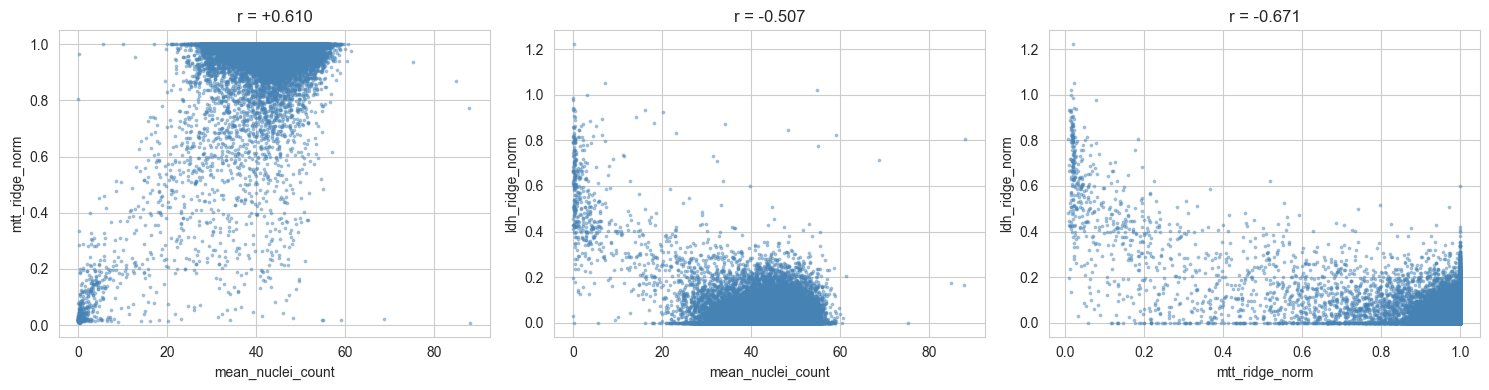

In [27]:
# quick scatter pairs for the three checks
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (a, b, _) in zip(axes, checks):
    valid = feat_numeric[[a, b]].dropna()
    ax.scatter(valid[a], valid[b], s=3, alpha=0.4, color="steelblue")
    ax.set_xlabel(a); ax.set_ylabel(b)
    r = valid[[a, b]].corr().iloc[0, 1]
    ax.set_title(f"r = {r:+.3f}")
plt.tight_layout(); plt.show()


## 11  Summary & notes

* Total wells (n = 24,576) / compounds (n = 1,098) / DMSO wells (n = 4,416)
* Replicate structure: 16 replicates (wells per compound)
* Annotation coverage: 50/1,099 compounds lack annotations
* Majority of sources have all scalar features 
	* Source 25: cyto_area_ratio_ridge_norm has 6% missing, vacuole_ratio has 9% missing, 
	* Source 30: ldh_ridge_norm has 0.5% missing
* Strongest positive & negative feature correlations:
	* positive: mean_nuclei_count_ridge_norm and cyto_area_ratio_ridge_norm
	* negative: mean_nuclei_count_ridge_norm and mean_nuclei_count_ridge_norm_inv
* All three sanity-check relationships confirmed!
